<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/code/Predicting_Semantic_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ColabFiles/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ColabFiles


In [71]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [92]:
import pandas as pd
import re
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from functools import reduce
import random as r

In [3]:
!pip install matplotlib --upgrade
%%capture
import matplotlib.pyplot as plt
import matplotlib as mpl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
# import factor  datasets

# https://saifmohammad.com/WebPages/nrc-vad.html
val_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/NRC-VAD-Lexicon.txt', sep="\t", header=None)
val_df = val_df.rename(columns={0:'Word', 1:'val', 2:'aro', 3:'dom'})[['Word', 'val', 'aro', 'dom']]

conc_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/brysbaert_concreteness.csv')
conc_df = conc_df.rename(columns={'Conc.M': 'conc'})[['Word', 'conc']]

freq_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/COCA_freqs.csv', encoding='ISO-8859-1') # w1, coca_spok
freq_df = freq_df.rename(columns={'w1':'Word', 'coca_spok':'freq'})[['Word', 'freq']]
freq_df['freq_rank'] = freq_df['freq'].rank(ascending=False)

In [5]:
# import semantic shift dataset

sem_shift_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/Project 10 Datasets/cleaned_dat_sem_shift.csv')
sem_shift_df['meaning1'] = sem_shift_df['meaning1_clean']
sem_shift_df['meaning2'] = sem_shift_df['meaning2_clean']

sem_shift_df.at[697, 'meaning1'] = 'furuncul'
sem_shift_df.at[1521, 'meaning2'] = 'geometrid'

In [ ]:
#@title english data

# sem_shift_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/cleaned_classified_df.csv', encoding='ISO-8859-1')

# #remove nan rows
# sem_shift_df['Bleached sense'] = sem_shift_df['Bleached sense'].fillna('NaN')
# sem_shift_df = sem_shift_df[sem_shift_df['Bleached sense']!='NaN']

# # remove completely duplicated rows
# sem_shift_df = sem_shift_df[~sem_shift_df.duplicated()]

# # get rid of punctuation in the senses

# def cleanString(s):
#   s = s.lower()
#   s = s.replace("'", "")
#   s = s.replace(",", "")
#   s = s.replace(";", "")
#   s = s.lower()
#   return s

# sem_shift_df['meaning1'] = sem_shift_df['meaning1'].apply(cleanString)
# sem_shift_df['meaning2'] = sem_shift_df['meaning2'].apply(cleanString)

# # maybe filter this out for testing  
# # sem_shift_df = sem_shift_df[sem_shift_df['Type of change']!= 'synaesthesia']

In [6]:
# define how we map a sense to concreteness, valence, frequency values

skip_words = {'the', 'and', 'of', 'a', 'in', 'to', 'it', 'is', 'that', 'for', 'with', 'on', 'at', 'this', 'that', 'by', 'or', 'an', 'as', 'if', 'so', 'in'}

# take all words in the sense and and average/add values
# if conservative, only matches to full phrases separated by "or"
def senseToValue(s, df, col, average=True, conservative=False):
  s = s.lower()
  if conservative: 
    phrases = re.split(' or ', s)
  else:
    for i in "(),/":
      s = s.replace(i, "")
    phrases = re.split(' ', s)
  total_val = 0
  val_data = 0
  for p in phrases:
    if p in skip_words:
      continue
    try:
      val = df[df['Word']==p][col].values[0]
      if not np.isnan(val):
        total_val += val
        val_data += 1
    except:
      pass
  if val_data == 0:
    total_val = np.nan
  else:
    if average:
      total_val /= val_data
  return total_val

In [7]:
# get priors for semshift data

# dictionary for concreteness and embeddings
conc_dic = {} # This will be a dictionary that easily allows us to access the concreteness for all of our senses, saving time. 
freq_dic = {} 
val_dic = {} 

conservative=False

for i in range(len(sem_shift_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = sem_shift_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  if x not in conc_dic:
    x_conc = senseToValue(x, conc_df, 'conc', conservative=conservative)
    if not np.isnan(x_conc):
      conc_dic[x] = x_conc

  if y not in conc_dic:
    y_conc = senseToValue(y, conc_df, 'conc', conservative=conservative)
    if not np.isnan(y_conc):
      conc_dic[y] = y_conc

  if x not in freq_dic:
    x_freq = senseToValue(x, freq_df, 'freq', average=True, conservative=conservative)
    if not np.isnan(x_freq):
      freq_dic[x] = x_freq

  if y not in freq_dic:
    y_freq = senseToValue(y, freq_df, 'freq', average=True, conservative=conservative)
    if not np.isnan(y_freq):
      freq_dic[y] = y_freq

  if x not in val_dic:
    x_val = senseToValue(x, val_df, 'val', conservative=conservative)
    if not np.isnan(x_val):
      val_dic[x] = x_val

  if y not in val_dic:
    y_val = senseToValue(y, val_df, 'val', conservative=conservative)
    if not np.isnan(y_val):
      val_dic[y] = y_val

In [8]:
#@title export these as a dataframe, for use in other places

# conc_sense_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'conc'})
# freq_sense_df = pd.DataFrame.from_dict(freq_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'freq'})
# val_sense_df = pd.DataFrame.from_dict(val_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'val'})

# df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df[['meaning1', 'meaning2']], conc_sense_df])
# df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [df, conc_sense_df])
# df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [df, freq_sense_df])
# df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [df, freq_sense_df])
# df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [df, val_sense_df])
# df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [df, val_sense_df])

# df = df.drop(['Word_x', 'Word_y'], axis=1)

# df.to_csv('all_vars_df.csv', index=False)

In [9]:
# test prior accuracy

# merge concreteness with shift df
conc_sense_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'conc'})
shift_conc_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, conc_sense_df])
shift_conc_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_conc_df, conc_sense_df])

# calculate ratio and find accuracy
shift_conc_df['ratio'] = shift_conc_df['conc_x'] / shift_conc_df['conc_y']
shift_conc_df = shift_conc_df[~np.isnan(shift_conc_df['ratio'])]
shift_conc_df['ratio_accurate'] = shift_conc_df['ratio'] > 1
print(shift_conc_df['ratio_accurate'].value_counts())
print("accuracy: ", shift_conc_df['ratio_accurate'].value_counts()[True] / len(shift_conc_df), "with ", len(shift_conc_df) , "samples")
conc_accuracy = shift_conc_df['ratio_accurate'].value_counts()[True] / len(shift_conc_df)

True     2006
False     841
Name: ratio_accurate, dtype: int64
accuracy:  0.7046013347383211 with  2847 samples


In [10]:
#@title english data stuff
# print("accuracy w/o syn: ", shift_conc_df[shift_conc_df['Type of change']!='synaesthesia']['ratio_accurate'].value_counts()[True] / len(shift_conc_df[shift_conc_df['Type of change']!='synaesthesia']), "with ", len(shift_conc_df[shift_conc_df['Type of change']!='synaesthesia']) , "samples")
# accuracy_df = pd.DataFrame()
# accuracy_df['accuracy'] = shift_conc_df.groupby('Type of change').sum()['ratio_accurate'] / shift_conc_df.groupby('Type of change').size()
# accuracy_df['realizations'] = shift_conc_df.groupby('Type of change').size()
# print(accuracy_df.to_latex(index=True))

In [11]:
# test prior accuracy

# merge freqreteness with shift df
freq_sense_df = pd.DataFrame.from_dict(freq_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'freq'})
shift_freq_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, freq_sense_df])
shift_freq_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_freq_df, freq_sense_df])

# calculate ratio and find accuracy
shift_freq_df['ratio'] = shift_freq_df['freq_x'] / shift_freq_df['freq_y']
shift_freq_df = shift_freq_df[~np.isnan(shift_freq_df['ratio'])]
shift_freq_df['ratio_accurate'] = shift_freq_df['ratio'] > 1
print(shift_freq_df['ratio_accurate'].value_counts())
print("accuracy: ", shift_freq_df['ratio_accurate'].value_counts()[True] / len(shift_freq_df), "with ", len(shift_freq_df) , "samples")
freq_accuracy = shift_freq_df['ratio_accurate'].value_counts()[True] / len(shift_freq_df)

True     1489
False    1383
Name: ratio_accurate, dtype: int64
accuracy:  0.5184540389972145 with  2872 samples


In [12]:
#@title english data stuff
# print("accuracy w/o syn: ", shift_freq_df[shift_freq_df['Type of change']!='synaesthesia']['ratio_accurate'].value_counts()[True] / len(shift_freq_df[shift_freq_df['Type of change']!='synaesthesia']), "with ", len(shift_freq_df[shift_freq_df['Type of change']!='synaesthesia']) , "samples")
# accuracy_df = pd.DataFrame()
# accuracy_df['accuracy'] = shift_freq_df.groupby('Type of change').sum()['ratio_accurate'] / shift_freq_df.groupby('Type of change').size()
# accuracy_df['realizations'] = shift_freq_df.groupby('Type of change').size()
# print(accuracy_df.to_latex(index=True))

In [13]:
# test prior accuracy

# merge valreteness with shift df
val_sense_df = pd.DataFrame.from_dict(val_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'val'})
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, val_sense_df])
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_val_df, val_sense_df])

# calculate ratio and find accuracy
shift_val_df['ratio'] = shift_val_df['val_x'] / shift_val_df['val_y']
shift_val_df = shift_val_df[~np.isnan(shift_val_df['ratio'])]
shift_val_df['ratio_accurate'] = shift_val_df['ratio'] > 1
print(shift_val_df['ratio_accurate'].value_counts())
print("accuracy: ", shift_val_df['ratio_accurate'].value_counts()[True] / len(shift_val_df), "with ", len(shift_val_df) , "samples")
val_accuracy = shift_val_df['ratio_accurate'].value_counts()[True] / len(shift_val_df)

True     1333
False    1298
Name: ratio_accurate, dtype: int64
accuracy:  0.5066514633219308 with  2631 samples


In [14]:
#@title english data stuff

# print("accuracy w/o syn: ", shift_val_df[shift_val_df['Type of change']!='synaesthesia']['ratio_accurate'].value_counts()[True] / len(shift_val_df[shift_val_df['Type of change']!='synaesthesia']), "with ", len(shift_val_df[shift_val_df['Type of change']!='synaesthesia']) , "samples")

# accuracy_df = pd.DataFrame()
# accuracy_df['accuracy'] = shift_val_df.groupby('Type of change').sum()['ratio_accurate'] / shift_val_df.groupby('Type of change').size()
# accuracy_df['realizations'] = shift_val_df.groupby('Type of change').size()
# print(accuracy_df.to_latex(index=True))

## logistic regression

In [115]:
shift_df = sem_shift_df[['meaning1', 'meaning2']]

# choose which are going to shift
indices = list(range(len(shift_df)))
r.shuffle(indices)
switch_indices = indices[:int(len(shift_df)/2)]

# set the accuracy column
shift_df['accurate'] = pd.Series(dtype='boolean')
shift_df.loc[switch_indices, 'accurate'] = False
shift_df.loc[indices[int(len(shift_df)/2):], 'accurate'] = True

shift_df.loc[switch_indices, 'meaning1'] = sem_shift_df.loc[switch_indices, 'meaning2']
shift_df.loc[switch_indices, 'meaning2'] = sem_shift_df.loc[switch_indices, 'meaning1']

In [116]:
# merge in freq/conc/val data

shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_df, conc_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_df, conc_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_df, freq_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_df, freq_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_df, val_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_df, val_sense_df]).drop('Word', axis=1)

In [117]:
# filter the dataframe and add various test columns 

shift_df = shift_df.dropna()

shift_df['freq_x'] = np.log(shift_df['freq_x'])
shift_df['freq_y'] = np.log(shift_df['freq_y'])

shift_df['conc_diff'] = shift_df['conc_y'] - shift_df['conc_x']
shift_df['freq_diff'] = shift_df['conc_y'] - shift_df['freq_x']
shift_df['val_diff'] = shift_df['val_y'] - shift_df['val_x']

shift_df['conc_ratio'] = shift_df['conc_x'] / shift_df['conc_y']
shift_df['freq_ratio'] = shift_df['freq_x'] / shift_df['freq_y']
shift_df['val_ratio'] = shift_df['val_x'] / shift_df['val_y']

shift_df['conc_acc'] = shift_df['conc_ratio'] > 1
shift_df['freq_acc'] = shift_df['freq_ratio'] > 1
shift_df['val_acc'] = shift_df['val_ratio'] > 1

In [118]:
# run logistic regression

X = shift_df[['conc_acc', 'freq_acc', 'val_acc']].copy().to_numpy()
y = shift_df['accurate'].copy().to_numpy()
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

log_accuracy = model.score(X_test,y_test)

## figures

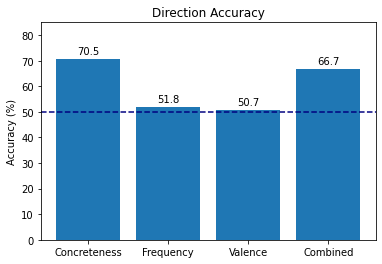

In [119]:
#@title FIG 1.D -- Direction Accuracy

heights = [conc_accuracy, freq_accuracy, val_accuracy, log_accuracy]
heights = [round(i*100, 1) for i in heights]

x = np.arange(len(heights))  # the label locations

fig, ax = plt.subplots()
rects = ax.bar(x, heights)

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Direction Accuracy')
ax.set_xticks(x, labels=['Concreteness', 'Frequency', 'Valence', 'Combined'])
ax.bar_label(rects, padding=3)
ax.set_ylim(0, 85)

ax.axhline(50, linestyle='--', c='navy')

plt.show()

# so much stuff that probably doesn't matter anymore

## accuracy for concreteness, frequency, and valence

#### on cleaned data
NOT conservative:
* 68.5 with 2849 samples
* 51.6 with 2874 samples
* 50.6 with 2631 samples

conservative:
* 73.5 with 1048 samples
* 54.8 with 1013 samples
* 55.3 with 889 samples

## testing logsistic regression

In [ ]:
# normalize

from scipy.special import softmax

conc_sense_df['normalized_conc'] = conc_sense_df['conc'] # softmax(conc_sense_df['conc'])
freq_sense_df['normalized_freq'] = np.log(freq_sense_df['freq']) # softmax(freq_sense_df['freq'])
val_sense_df['normalized_val'] = val_sense_df['val'] # softmax(conc_sense_df['conc'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
shift_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, conc_sense_df])
shift_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_vars_df, conc_sense_df])
shift_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_vars_df, freq_sense_df])
shift_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_vars_df, freq_sense_df])
shift_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_vars_df, val_sense_df])
shift_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_vars_df, val_sense_df])

shift_vars_df['freq_diff'] = shift_vars_df['normalized_freq_y'] - shift_vars_df['normalized_freq_x']
shift_vars_df['conc_diff'] = shift_vars_df['normalized_conc_y'] - shift_vars_df['normalized_conc_x']
shift_vars_df['val_diff'] = shift_vars_df['normalized_val_y'] - shift_vars_df['normalized_val_x']

shift_vars_df['freq_ratio'] = shift_vars_df['normalized_freq_x']/ shift_vars_df['normalized_freq_y']
shift_vars_df['conc_ratio'] = shift_vars_df['normalized_conc_x']/shift_vars_df['normalized_conc_y']
shift_vars_df['val_ratio'] = shift_vars_df['normalized_val_x']/shift_vars_df['normalized_val_y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Word_x'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Word_x'} in the result is deprecated and will raise a MergeError in a future version.
  


In [ ]:
shift_vars_df

,Unnamed: 0,meaning1,meaning2,meaning1_clean,meaning2_clean,Word_x,conc_x,normalized_conc_x,Word_y,conc_y,...,normalized_val_x,Word_y,val_y,normalized_val_y,freq_diff,conc_diff,val_diff,freq_ratio,conc_ratio,val_ratio
0,0,gunpowder,quick,gunpowder,quick,gunpowder,4.790,4.790,quick,2.890,...,0.4250,quick,0.7040,0.7040,5.283445,-1.900,0.2790,0.414325,1.657439,0.603693
1,1,gunpowder,small quantity of something,gunpowder,small quantity of something,gunpowder,4.790,4.790,small quantity of something,2.670,...,0.4250,small quantity of something,0.5310,0.5310,7.910774,-2.120,0.1060,0.320873,1.794007,0.800377
2,2,August,harvest,August,harvest,August,3.040,3.040,harvest,4.000,...,0.6520,harvest,0.7810,0.7810,-2.597417,0.960,0.1290,1.447667,0.760000,0.834827
3,3,common weed,potato,common weed,potato,common weed,3.485,3.485,potato,4.850,...,0.5295,potato,0.5410,0.5410,-2.386797,1.365,0.0115,1.359393,0.718557,0.978743
4,4,Easter,ladybird,Easter,ladybird,Easter,2.830,2.830,ladybird,4.760,...,NaN,NaN,NaN,NaN,NaN,1.930,NaN,NaN,0.594538,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2936,young man,soldier,young man,soldier,young man,3.975,3.975,soldier,4.720,...,NaN,soldier,0.3920,0.3920,-3.547499,0.745,NaN,1.442809,0.842161,NaN
2937,2937,younger brother,bear,younger brother,bear,younger brother,3.610,3.610,bear,4.880,...,0.8230,bear,0.4480,0.4480,-1.931580,1.270,-0.3750,1.254666,0.739754,1.837054
2938,2938,younger brother,husband,younger brother,husband,younger brother,3.610,3.610,husband,4.110,...,0.8230,husband,0.7710,0.7710,0.041258,0.500,-0.0520,0.995683,0.878345,1.067445
2939,2939,younger brother,owner,younger brother,owner,younger brother,3.610,3.610,owner,3.780,...,0.8230,owner,0.7760,0.7760,-1.556728,0.170,-0.0470,1.195578,0.955026,1.060567


In [ ]:
shift_vars_df = shift_vars_df[~shift_vars_df[['freq_ratio', 'conc_ratio', 'val_ratio']].isin([np.nan, np.inf, -np.inf]).any(1)]

In [ ]:
import random

#df = shift_vars_df_filtered[['meaning1', 'meaning2', 'conc_diff', 'freq_diff', 'conc_ratio', 'freq_ratio']]
df = shift_vars_df

indices = list(range(len(df)))
random.shuffle(indices)
switch_indices = indices[:int(len(df)/2)]

left_df = df.iloc[switch_indices].copy()
left_df.loc[:,'meaning2'] = df['meaning1']
left_df.loc[:,'meaning1'] = df['meaning2']
left_df.loc[:,'conc_ratio'] = 1/left_df['conc_ratio']
left_df.loc[:,'freq_ratio'] = 1/left_df['freq_ratio']
left_df.loc[:,'val_ratio'] = 1/left_df['val_ratio']
left_df.loc[:,'accurate'] = False

right_df = df.iloc[indices[int(len(df)/2):]].copy()
right_df.loc[:,'accurate'] = True

shuffled_df = pd.concat([left_df, right_df]).sort_index()

shuffled_df = shuffled_df[~np.isinf(shuffled_df['freq_ratio']) & ~(np.isinf(shuffled_df['conc_ratio']))]

In [ ]:
shuffled_df = shuffled_df[shuffled_df['Type of change']!='synaesthesia']

In [ ]:
len(shuffled_df)

2573

In [ ]:
# logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

shuffled_df['conc'] = np.where(shuffled_df['conc_ratio']>1, 1, 0)
shuffled_df['freq'] = np.where(shuffled_df['freq_ratio']>1, 1, 0)
shuffled_df['val'] = np.where(shuffled_df['val_ratio']>1, 1, 0)

X = shuffled_df[['conc_ratio', 'freq_ratio', 'val_ratio']].copy().to_numpy()
y = shuffled_df['accurate'].copy().to_numpy()

acc = 0
coefs = [0,0,0]

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

  model = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train, y_train)

  acc += model.score(X_test, y_test)

  coefs += model.coef_

acc /= 10
print(acc)
coefs /= 10
print(coefs)

print(model.score(X_test,y_test))

print(confusion_matrix(y_test, model.predict(X_test)))

# softmax normalization is making the frequency distribution unusable 
# and making the concreteness distribution slightly worse
# but with neither of them normalized (and log frequency) we're getting ~60% accuracy 

0.7097087378640776
[[2.90636506 0.13967468 0.08172524]]
0.7126213592233009
[[215  47]
 [101 152]]


In [ ]:
model.coef_

array([[2.928876  , 0.07877863, 0.12120622]])

In [ ]:
shuffled_df['ratio_accurate'] = shuffled_df['conc'] == shuffled_df['accurate']
print(shuffled_df['ratio_accurate'].value_counts())
print("accuracy: ", shuffled_df['ratio_accurate'].value_counts()[True] / len(shuffled_df), "with ", len(shuffled_df) , "samples")

True     639
False    217
Name: ratio_accurate, dtype: int64
accuracy:  0.7464953271028038 with  856 samples
